# CitiBike 
## Part 3: Predicting Available Bikes Using Time-Series Methods
The Citi Bike system is a bicycle ride sharing system based in New York City where users can rent bikes for short periods of time. Users pick up a bike at a station, and ride to another station where they drop the bike off. The bikes are used for commuting, sight seeing, and general travelling throughout the city.

During high traffic times it can be difficult to determine if a Citi Bike will be available at a given station at a given time in the future. This could be especially useful for commuters to determine when they should leave for work or leave from work to ensure a Citi Bike is available.

<img src="citi_bike_rad_dude.jpg" width=600 height=400 />

The goal of this project is to develop a predictive model to enable Citi Bike users to determine the probability of a Citi Bike being available at somepoint in the future. This is based on the Citi Bike trips data set, as well as Citi Bike Stations Live feed. The trips data set contains information on a trip level, with a start and stop destination as well as some basic information regarding the user. The Station Live Feed contains information on stations, such as the total docks available at a given station.

This notebook can be separated into the following parts:
- Initial data importing and cleaning

- Identifying missing trips, and imputing/simulating the missing trips

- Developing a statistical model to identify broken bikes and simulate removal


In [1]:
import pandas as pd
import numpy as np
import os
import stat
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime as dt
import data_processing as data_processing
import importlib
importlib.reload(data_processing)
import tensorflow as tf
from tensorflow import keras

### Read Trips Data

I start by importing the May 2020 trips dataset.

In [2]:
folder = os.getcwd()
zip_file = '/202005-citibike-tripdata.csv.zip'
zip_file_path = folder + zip_file
trips = data_processing.process_monthly_trips(zip_file_path)

stations = pd.read_csv(folder + '/station_feed_06-24-20.csv')

In [3]:
trips.head()

,tripduration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,usertype,birth_year,gender
0,336,2020-05-01 00:01:06.338,2020-05-01 00:06:42.956,2017,E 43 St & 2 Ave,40.750224,-73.971214,465,Broadway & W 41 St,40.755136,-73.986580,18015,Subscriber,1993,1
1,853,2020-05-01 00:01:08.195,2020-05-01 00:15:21.215,3376,E 65 St & 2 Ave,40.764719,-73.962221,478,11 Ave & W 41 St,40.760301,-73.998842,35905,Subscriber,1989,1
2,78,2020-05-01 00:01:08.526,2020-05-01 00:02:27.049,396,Lefferts Pl & Franklin Ave,40.680342,-73.955769,3789,Fulton St & Irving Pl,40.681860,-73.959432,33350,Subscriber,1938,2
3,1185,2020-05-01 00:02:22.438,2020-05-01 00:22:08.122,3630,Frederick Douglass Blvd & W 115 St,40.803865,-73.955931,3506,Lexington Ave & E 120 St,40.801307,-73.939817,43790,Subscriber,1996,1
4,272,2020-05-01 00:02:32.828,2020-05-01 00:07:05.088,3776,Central Ave & Starr Street,40.700003,-73.928340,3068,Humboldt St & Varet St,40.703172,-73.940636,39912,Subscriber,1993,1


In [4]:
# Convert trips to ops
ops = data_processing.convert_trips_to_ops(trips)

# Fill missing ops
ops = data_processing.fill_missing_ops(trips, ops)

In [5]:
# Fill status updates
ops = data_processing.insert_status_updates(stations, ops)

# Calculate the new number of starting bikes
ops['sum_net_bikes'] = ops.groupby('station_id')['net_bikes'].cumsum()
offset = ops[ops.op_type=='status'][['station_id', 'available_bikes', 'sum_net_bikes']].copy()
offset['starting_bikes'] = offset['available_bikes'] - offset['sum_net_bikes']

In [6]:
ops = ops.merge(offset[['station_id', 'starting_bikes']], how='left', on='station_id')
ops['available_bikes'] = ops['sum_net_bikes'] + ops['starting_bikes']

In [15]:
stations[stations.id==3141]

,Unnamed: 0,id,stationName,availableDocks,totalDocks,latitude,longitude,statusValue,statusKey,availableBikes,stAddress1,stAddress2,city,postalCode,location,altitude,testStation,lastCommunicationTime,landMark
353,353,3141,1 Ave & E 68 St,43,58,40.765005,-73.958185,In Service,1,13,1 Ave & E 68 St,NaN,NaN,NaN,NaN,NaN,False,2020-05-30 06:47:49 AM,NaN


In [16]:
temp = ops[ops.station_id==3141].copy()
temp['op_time'] = temp.op_time.dt.floor('s')
temp = temp.groupby('op_time')['available_bikes'].min().reset_index()
temp = temp.set_index('op_time')
temp = temp.resample('1S').ffill()
temp = temp.resample('1min').bfill()

In [17]:
temp.head()

,available_bikes
op_time,
2020-05-01 00:15:00,5.0
2020-05-01 00:16:00,5.0
2020-05-01 00:17:00,5.0
2020-05-01 00:18:00,5.0
2020-05-01 00:19:00,5.0


In [18]:
from statsmodels.tsa import holtwinters
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose time series, add 1 to make non-negative
ts_model = seasonal_decompose(temp, model='additive', freq=60*24)

C:\Users\MM28818\Documents\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """


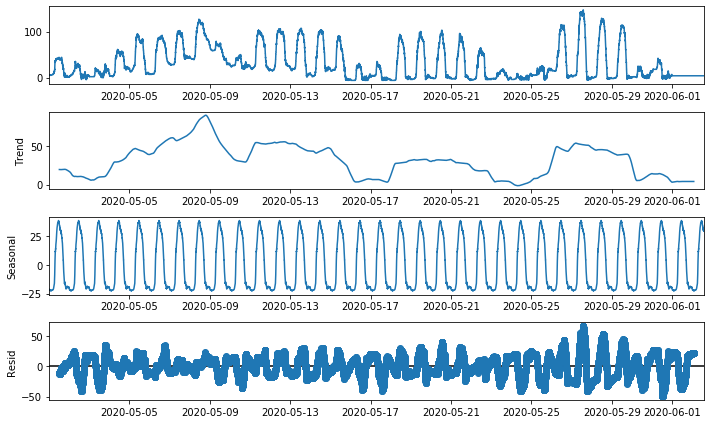

In [19]:
plt.rcParams['figure.figsize'] = [10, 6]
ts_model.plot()
plt.show()